In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import os
import json
import pickle
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as tud
from torch.autograd import Variable

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 24 products and Customer code 
dtype_list = {'fecha_dato': 'object', 'ncodpers': 'int64', 'ind_empleado': 'str','pais_residencia':'str', 'sexo':'str', 'age': 'int64', 'fecha_alta': 'object',
                'ind_nuevo': 'str', 'antiguedad':'int64', 'indrel': 'int32','ult_fec_cli_1t': 'object','indrel_1mes': 'int32', 'tiprel_1mes':'str','indresi': 'str',
                'indext': 'str','conyuemp': 'str', 'canal_entrada':'str','indfall': 'str','tipodom':'int32', 'cod_prov':'int64','nomprov': 'str','ind_actividad_cliente': 'int32',
                'renta': 'float64', 'segmento' :'str','ind_cco_fin_ult1': 'int16', 'ind_deme_fin_ult1': 'int16', 'ind_aval_fin_ult1': 'int16', 'ind_valo_fin_ult1': 'int16', 
                'ind_reca_fin_ult1': 'int16', 'ind_ctju_fin_ult1': 'int16','ind_cder_fin_ult1': 'int16', 'ind_plan_fin_ult1': 'int16', 'ind_fond_fin_ult1': 'int16',
                'ind_hip_fin_ult1': 'int16', 'ind_pres_fin_ult1': 'int16', 'ind_nomina_ult1': 'int16', 'ind_cno_fin_ult1': 'int16','ind_ctpp_fin_ult1': 'int16', 
                'ind_ahor_fin_ult1': 'int16', 'ind_dela_fin_ult1': 'int16', 'ind_ecue_fin_ult1': 'int16', 'ind_nom_pens_ult1': 'int16', 'ind_recibo_ult1': 'int16', 
                'ind_deco_fin_ult1': 'int16', 'ind_tjcr_fin_ult1': 'int16', 'ind_ctop_fin_ult1': 'int16', 'ind_viv_fin_ult1': 'int16', 'ind_ctma_fin_ult1': 'int16'}

In [3]:
train_0 = pd.read_csv("Dataset/reference_sample_001.csv",header = None,dtype = dtype_list,na_values = 'NA')
train_0.columns = ['Month_status_date', 'Customer_ID', 'Employee_Index', 'Customer_country', 'Sex', 'Age', 'Join_date',
                'New_customer', 'Relnshp_Mnths', 'Relnshp_flag','Last_date_Prim_Cust', 'Cust_type_beg_Mth', 'Cust_Reln_type_beg_mth',
                'Residence_flag', 'Foreigner_flag', 'Emp_spouse_flag', 'Channel_when_joined', 'Deceased_flag', 
                'Address_type', 'Customer_address', 'Address_detail', 'Activity_flag', 'Gross_household_income',
                'Segment', 'Saving_account', 'Guarantees', 'Cur_account', 'Derivative_account', 'Payroll_account',
                'Junior_account', 'Particular_acct1', 'Particular_acct2', 'Particular_acct3', 'Short_term_deposites',
                'Med_term_deposites', 'Long_term_deposites', 'e-account', 'Funds', 'Mortgage', 'Pension', 'Loans',
                'Taxes', 'Credit_card', 'Securities', 'Home_account', 'Payroll', 'Pensions', 'Direct_debit']

In [4]:
train_1= train_0[1:]

In [5]:
unique_var = ['Customer_ID']
cont_var = ['Age','Relnshp_Mnths','Gross_household_income']
cate_var = ['Employee_Index','Sex','New_customer','Relnshp_flag','Cust_type_beg_Mth','Cust_Reln_type_beg_mth','Residence_flag',
            'Foreigner_flag','Emp_spouse_flag','Deceased_flag','Address_type','Activity_flag','Segment']
target_var = ['Saving_account','Guarantees','Cur_account','Derivative_account','Payroll_account','Junior_account','Particular_acct1',
              'Particular_acct2','Particular_acct3','Short_term_deposites','Med_term_deposites','Long_term_deposites','e-account', 
              'Funds','Mortgage','Pension','Loans','Taxes','Credit_card','Securities','Home_account','Payroll','Pensions','Direct_debit']
cate_var_date = ['Month_status_date','Join_date','Last_date_Prim_Cust']
cate_var_big = ['Customer_country','Channel_when_joined','Customer_address','Address_detail',]
cate_var_int = ['New_customer','Relnshp_flag','Activity_flag','Address_type']

In [6]:
for ind_, var_ in enumerate(cont_var):
    train_1[var_] = pd.to_numeric(train_1[var_],errors='coerce')

In [7]:
# Missing values for continuous variable - Train
for ind,var in enumerate(cont_var):
    train_1[var] = train_1[var].replace(to_replace = ['NA',' NA','         NA',-999999], value = np.nan)
    train_1[var].fillna(pd.to_numeric(train_1[var],errors='coerce').dropna().mean(),inplace=True)

# Missing values for categorical variable - Train
for ind,var in enumerate(cate_var):
    train_1[var] = train_1[var].replace(to_replace = ['NA',' NA','     NA'], value = np.nan)
    train_1[var].fillna(train_1[var].value_counts().index[0],inplace=True)
    
for ind,var in enumerate(cate_var_big):
    train_1[var] = train_1[var].replace(to_replace = ['NA',' NA','     NA'], value = np.nan)
    train_1[var].fillna(train_1[var].value_counts().index[0],inplace=True)
    
for ind,var in enumerate(target_var):
    train_1[var] = train_1[var].replace(to_replace = ['NA',' NA','     NA'], value = np.nan)
    train_1[var].fillna(train_1[var].value_counts().index[0],inplace=True)
    
for ind,var in enumerate(cate_var_date):
    train_1[var] = train_1[var].replace(to_replace = ['NA',' NA','     NA'], value = np.nan)
    train_1[var].fillna(train_1[var].value_counts().index[0],inplace=True)

In [8]:
for ind, var in enumerate(cate_var_int): 
    train_1[var] = train_1[var].astype(float).astype(int)
for ind, var in enumerate(target_var):
    train_1[var] = train_1[var].astype(int)

In [9]:
###############################################################################

In [10]:
str_ = ['Employee_Index','Customer_country','Sex','New_customer','Relnshp_flag','Cust_type_beg_Mth','Cust_Reln_type_beg_mth','Residence_flag','Foreigner_flag', 'Emp_spouse_flag', 'Channel_when_joined','Address_type','Deceased_flag','Customer_address','Address_detail','Activity_flag','Segment']
# string to categorical
train_1[str_] = train_1[str_].astype('category')
# Dropping Data columns
train_1.drop(columns=cate_var_date,inplace=True)

In [11]:
le = preprocessing.OneHotEncoder(sparse=False)
for column_name in str_:
    train_1[column_name] = le.fit_transform(np.array(train_1[column_name].astype(str)).reshape(-1,1)).astype(float)

In [12]:
train_rf,test_rf = train_test_split(train_1, test_size = 0.2)

In [14]:
# Creating Random Forest Classifiers for each product
df_train = []
precision_train = []
recall_train =[]
f1_score_train = []
#shutil.rmtree("Trained Model")   # To delete already created folder
if os.path.exists("Trained Model") is False:
    os.mkdir("Trained Model")
    os.mkdir("Trained Model/Random Forest_trial")
        
for ind, var in enumerate(target_var):
    clf = RandomForestClassifier(n_jobs=2, random_state=0)
    # Training the classifier
    clf.fit(train_rf[train_rf.columns[1:20]],train_rf[var])
    # Saving the classifier                                    # create folder
    with open('Trained Model/Random Forest_trial/'+str(var),'wb') as f:
        pickle.dump(clf,f)
    
    df_train.append((clf.predict(train_rf[train_rf.columns[1:20]])))
    precision_train.append( precision_score(train_rf[var],clf.predict(train_rf[train_rf.columns[1:20]])) )
    recall_train.append( recall_score(train_rf[var],clf.predict(train_rf[train_rf.columns[0:20]])) )
    f1_score_train.append( f1_score(train_rf[var],clf.predict(train_rf[train_rf.columns[0:20]])) )

In [ ]:
# Testing SVM Classifiers for each product
df_test = []
precision_test = []
recall_test =[]
f1_score_test = []

for ind, var in enumerate(target_var):
    # Loading the classifier
    clf_1 = pickle.load(open('Trained Model/Random Forest_trial_1/'+str(var), 'rb'))
    
    df_test.append((clf_1.predict(test_rf[test_rf.columns[1:21]])))
    precision_test.append( precision_score(test_rf[var],clf_1.predict(test_rf[test_rf.columns[1:21]])) )
    recall_test.append( recall_score(test_rf[var],clf_1.predict(test_rf[test_rf.columns[1:21]])) )
    f1_score_test.append( f1_score(test_rf[var],clf_1.predict(test_rf[test_rf.columns[1:21]])) )

In [17]:
t1 = pd.DataFrame(np.array(precision_train),columns=['Precision_Train'])
t1['Recall_Train'] = pd.DataFrame(np.array(recall_train))
t1['F1_score_Train'] = pd.DataFrame(np.array(f1_score_train))
t1['Precision_Test'] = pd.DataFrame(np.array(precision_test))
t1['Recall_Test'] = pd.DataFrame(np.array(recall_test))
t1['F1_score_Test'] = pd.DataFrame(np.array(f1_score_test))

print("random forest generation completed.")
t1.to_csv('Random Forest_trial.csv')
print("wrtitng confusion matrix completed...")

In [18]:
train_2 = train_1[train_1.columns[21:]]
train_rbm = np.array(train_2)
train_rbm = np.reshape(train_rbm, (127110,24,1))
train_rbm,test_rbm = train_test_split(train_rbm, test_size = 0.2)
train_rbm = torch.FloatTensor(train_rbm)
test_rbm = torch.FloatTensor(test_rbm)

In [22]:
print(train_rbm.size())
print(test_rbm.size())

torch.Size([25422, 24, 1])


In [53]:
# RBM Modelling

class RBM():
    def __init__(self, nv, nh, r):
        self.W = torch.randn(r, nh, nv)*0.1
        self.a = torch.randn(1,1,nh)*0.01
        self.b = torch.randn(1,1,nv)*0.01
        
    def sample_h(self,x):
        wx = torch.matmul(x.permute(2,0,1), self.W.permute(0,2,1))
        activation = wx + self.a.expand_as(wx)
        p = torch.sigmoid(activation)
        return p, p.bernoulli()

    def sample_v(self,y):
        wy = torch.matmul(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p = torch.sigmoid(activation.permute(1,2,0))
        return p, p.bernoulli()
    
    def train_rbm_fn(self,v0,vk,ph0,phk,batch_size,learning_rate = 0.00001):
        self.W += learning_rate * (torch.matmul(v0.permute(2,1,0),ph0) - torch.matmul(vk.permute(2,1,0), phk)).permute(0,2,1)/ batch_size
        self.b += learning_rate * torch.sum(torch.sum((v0-vk).permute(2,0,1),1),0)/ batch_size
        self.a += learning_rate * torch.sum(torch.sum((ph0-phk),1),0)/ batch_size
    
    def free_energy(self, v):
        v_term = -torch.sum(torch.matmul(v.permute(2,0,1), self.b.permute(0,2,1)),dim=0)
        wx = torch.matmul(v.permute(2,0,1), self.W.permute(0,2,1))
        w_x_h = wx + self.a.expand_as(wx)
        h_term = -torch.sum(torch.sum(F.softplus(w_x_h),dim=2),dim=0)
        fe = torch.mean((h_term+v_term))
        return fe

In [54]:
nv = 24
nh = 1000
r = 1   # No. of star ratings
rbm = RBM(nv,nh,r)
batch_size = 1
k1 = 1

nb_epoch = 80
no_users = len(train_rbm)
errors_train = []
energy_train = []
energy_valid = []

for epoch in range(0,nb_epoch):
    train_loss = 0
    s = 0.
    for id_user in range(0,no_users,batch_size):
        vk = train_rbm[id_user:id_user+batch_size]
        v0 = train_rbm[id_user:id_user+batch_size]
        ph0,_ = rbm.sample_h(v0)
        for k in range(k1):
            _,hk = rbm.sample_h(vk)
            _,vk = rbm.sample_v(hk)
            vk[v0<=0] = v0[v0<=0]
            
        phk,_ = rbm.sample_h(vk)
        rbm.train_rbm_fn(v0,vk,ph0,phk,batch_size)
        train_loss += torch.mean((v0[v0>0] - vk[v0>0])**2)
        s += 1.
    etrain = torch.mean(rbm.free_energy(train_rbm))
    energy_train.append(etrain.item())
    etest = torch.mean(rbm.free_energy(test_rbm))
    energy_test.append(etest.item())
    errors_train.append((train_loss.item()/s)**0.5)
    if(epoch%1 == 0):
        print('epoch: '+str(epoch)+' loss: '+str((train_loss.item()/s)**0.5))

epoch: 0 loss: 0.284191781338524
epoch: 1 loss: 0.2543402700862232
epoch: 2 loss: 0.25100353176418133
epoch: 3 loss: 0.2472096645019028
epoch: 4 loss: 0.24487300598105463
epoch: 5 loss: 0.24156759077577028
epoch: 6 loss: 0.23886406083804035
epoch: 7 loss: 0.23572777851149415
epoch: 8 loss: 0.23303771470193893
epoch: 9 loss: 0.22989574094181844
epoch: 10 loss: 0.22774465685063536
epoch: 11 loss: 0.22531836782896633
epoch: 12 loss: 0.22293330860044186
epoch: 13 loss: 0.2210459019029971
epoch: 14 loss: 0.21871787250236188
epoch: 15 loss: 0.21728712999050692
epoch: 16 loss: 0.21531145395723056
epoch: 17 loss: 0.2134453099337078
epoch: 18 loss: 0.21187165354825235
epoch: 19 loss: 0.2102353970990038
epoch: 20 loss: 0.20903294269206607
epoch: 21 loss: 0.20785018096025545
epoch: 22 loss: 0.20684056171162424
epoch: 23 loss: 0.2053599045955035
epoch: 24 loss: 0.2041045843232423
epoch: 25 loss: 0.20348101692266832
epoch: 26 loss: 0.2021001987034315
epoch: 27 loss: 0.2016456711603736
epoch: 28 los

Text(0, 0.5, 'Error')

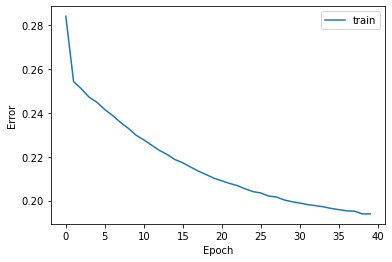

In [55]:
fig, ax = plt.subplots()
ax.plot(errors_train, label='train')
#ax.plot(errors_test, label='test')
leg = ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Error")

Text(0, 0.5, 'Free Energy')

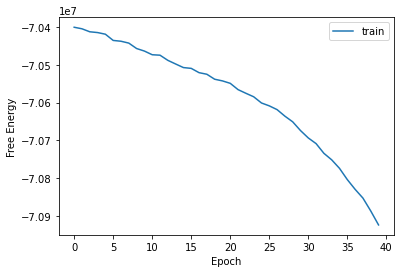

In [59]:
fig, ax = plt.subplots()
ax.plot(energy_train, label='train')
ax.plot(energy_test, label='test')
leg = ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Free Energy")